In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-08 10:51:46.355360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 10:51:46.355414: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-08 10:51:52.373141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 10:51:52.373202: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 10:51:52.373236: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-08 10:51:52.374075: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 2s 17ms/step - loss: 0.6918 - accuracy: 0.5530 - auc: 0.5681 - val_loss: 0.6701 - val_accuracy: 0.6284 - val_auc: 0.6976
Epoch 2/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.5640 - auc: 0.5783 - val_loss: 0.6660 - val_accuracy: 0.6513 - val_auc: 0.7159
Epoch 3/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6812 - accuracy: 0.5772 - auc: 0.5975 - val_loss: 0.6621 - val_accuracy: 0.6709 - val_auc: 0.7329
Epoch 4/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6792 - accuracy: 0.5755 - auc: 0.6006 - val_loss: 0.6583 - val_accuracy: 0.6857 - val_auc: 0.7473
Epoch 5/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6750 - accuracy: 0.5881 - auc: 0.6154 - val_loss: 0.6547 - val_accuracy: 0.6988 - val_auc: 0.7601
Epoch 6/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6703 - accuracy: 0.5972 - auc: 0.6265 - val_loss: 0.6512 - val_accuracy

39/39 [==============================] - 0s 7ms/step - loss: 0.4938 - accuracy: 0.7891 - auc: 0.8679 - val_loss: 0.4330 - val_accuracy: 0.8680 - val_auc: 0.9469
Epoch 49/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4906 - accuracy: 0.7919 - auc: 0.8688 - val_loss: 0.4263 - val_accuracy: 0.8702 - val_auc: 0.9488
Epoch 50/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4841 - accuracy: 0.7923 - auc: 0.8726 - val_loss: 0.4197 - val_accuracy: 0.8727 - val_auc: 0.9506
Epoch 51/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4786 - accuracy: 0.7959 - auc: 0.8765 - val_loss: 0.4131 - val_accuracy: 0.8760 - val_auc: 0.9524
Epoch 52/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4705 - accuracy: 0.8011 - auc: 0.8825 - val_loss: 0.4064 - val_accuracy: 0.8788 - val_auc: 0.9542
Epoch 53/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4705 - accuracy: 0.7966 - auc: 0.8807 - val_loss: 0.3999 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.3019 - accuracy: 0.8766 - auc: 0.9491 - val_loss: 0.2028 - val_accuracy: 0.9444 - val_auc: 0.9898
Epoch 96/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9457 - val_loss: 0.2001 - val_accuracy: 0.9453 - val_auc: 0.9901
Epoch 97/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.8748 - auc: 0.9457 - val_loss: 0.1974 - val_accuracy: 0.9462 - val_auc: 0.9904
Epoch 98/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2983 - accuracy: 0.8766 - auc: 0.9494 - val_loss: 0.1947 - val_accuracy: 0.9470 - val_auc: 0.9906
Epoch 99/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2983 - accuracy: 0.8739 - auc: 0.9493 - val_loss: 0.1921 - val_accuracy: 0.9475 - val_auc: 0.9908
Epoch 100/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3000 - accuracy: 0.8742 - auc: 0.9488 - val_loss: 0.1897 - val_acc

Epoch 142/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2187 - accuracy: 0.9098 - auc: 0.9718 - val_loss: 0.1206 - val_accuracy: 0.9677 - val_auc: 0.9964
Epoch 143/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2251 - accuracy: 0.9059 - auc: 0.9699 - val_loss: 0.1196 - val_accuracy: 0.9679 - val_auc: 0.9964
Epoch 144/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2208 - accuracy: 0.9061 - auc: 0.9710 - val_loss: 0.1186 - val_accuracy: 0.9681 - val_auc: 0.9965
Epoch 145/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2206 - accuracy: 0.9096 - auc: 0.9710 - val_loss: 0.1176 - val_accuracy: 0.9684 - val_auc: 0.9965
Epoch 146/394
39/39 [==============================] - 0s 11ms/step - loss: 0.2207 - accuracy: 0.9078 - auc: 0.9709 - val_loss: 0.1167 - val_accuracy: 0.9686 - val_auc: 0.9966
Epoch 147/394
39/39 [==============================] - 0s 9ms/step - loss: 0.2213 - accuracy: 0.9101 - auc: 0.9706 - val_los

Epoch 189/394
39/39 [==============================] - 1s 14ms/step - loss: 0.1742 - accuracy: 0.9288 - auc: 0.9819 - val_loss: 0.0874 - val_accuracy: 0.9766 - val_auc: 0.9981
Epoch 190/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1895 - accuracy: 0.9244 - auc: 0.9781 - val_loss: 0.0870 - val_accuracy: 0.9767 - val_auc: 0.9982
Epoch 191/394
39/39 [==============================] - 1s 13ms/step - loss: 0.1847 - accuracy: 0.9252 - auc: 0.9791 - val_loss: 0.0866 - val_accuracy: 0.9768 - val_auc: 0.9982
Epoch 192/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1791 - accuracy: 0.9285 - auc: 0.9805 - val_loss: 0.0861 - val_accuracy: 0.9770 - val_auc: 0.9982
Epoch 193/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1790 - accuracy: 0.9249 - auc: 0.9805 - val_loss: 0.0856 - val_accuracy: 0.9771 - val_auc: 0.9982
Epoch 194/394
39/39 [==============================] - 0s 13ms/step - loss: 0.1786 - accuracy: 0.9269 - auc: 0.9805 - val_l

Epoch 236/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1603 - accuracy: 0.9351 - auc: 0.9841 - val_loss: 0.0696 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 237/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9370 - auc: 0.9848 - val_loss: 0.0694 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 238/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1575 - accuracy: 0.9359 - auc: 0.9848 - val_loss: 0.0691 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 239/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1493 - accuracy: 0.9380 - auc: 0.9866 - val_loss: 0.0688 - val_accuracy: 0.9817 - val_auc: 0.9989
Epoch 240/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1534 - accuracy: 0.9382 - auc: 0.9856 - val_loss: 0.0685 - val_accuracy: 0.9819 - val_auc: 0.9989
Epoch 241/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9354 - auc: 0.9854 - val_loss

Epoch 283/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1360 - accuracy: 0.9444 - auc: 0.9887 - val_loss: 0.0582 - val_accuracy: 0.9848 - val_auc: 0.9993
Epoch 284/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1365 - accuracy: 0.9449 - auc: 0.9885 - val_loss: 0.0580 - val_accuracy: 0.9850 - val_auc: 0.9993
Epoch 285/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1373 - accuracy: 0.9437 - auc: 0.9885 - val_loss: 0.0579 - val_accuracy: 0.9849 - val_auc: 0.9993
Epoch 286/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1280 - accuracy: 0.9481 - auc: 0.9899 - val_loss: 0.0577 - val_accuracy: 0.9850 - val_auc: 0.9993
Epoch 287/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1306 - accuracy: 0.9466 - auc: 0.9894 - val_loss: 0.0574 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 288/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.9430 - auc: 0.9891 - val_loss

Epoch 330/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1175 - accuracy: 0.9537 - auc: 0.9914 - val_loss: 0.0497 - val_accuracy: 0.9882 - val_auc: 0.9995
Epoch 331/394
39/39 [==============================] - 0s 13ms/step - loss: 0.1162 - accuracy: 0.9515 - auc: 0.9917 - val_loss: 0.0495 - val_accuracy: 0.9881 - val_auc: 0.9995
Epoch 332/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1214 - accuracy: 0.9518 - auc: 0.9909 - val_loss: 0.0494 - val_accuracy: 0.9880 - val_auc: 0.9995
Epoch 333/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1157 - accuracy: 0.9543 - auc: 0.9917 - val_loss: 0.0492 - val_accuracy: 0.9882 - val_auc: 0.9995
Epoch 334/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1124 - accuracy: 0.9533 - auc: 0.9921 - val_loss: 0.0491 - val_accuracy: 0.9882 - val_auc: 0.9995
Epoch 335/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1169 - accuracy: 0.9500 - auc: 0.9917 - val_lo

Epoch 377/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1032 - accuracy: 0.9562 - auc: 0.9935 - val_loss: 0.0434 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 378/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1073 - accuracy: 0.9579 - auc: 0.9929 - val_loss: 0.0433 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 379/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9592 - auc: 0.9936 - val_loss: 0.0431 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 380/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1068 - accuracy: 0.9553 - auc: 0.9931 - val_loss: 0.0430 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 381/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1067 - accuracy: 0.9569 - auc: 0.9929 - val_loss: 0.0429 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 382/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1024 - accuracy: 0.9571 - auc: 0.9937 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.4227 - accuracy: 0.8278 - auc: 0.9079 - val_loss: 0.3403 - val_accuracy: 0.9114 - val_auc: 0.9755
Epoch 29/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4145 - accuracy: 0.8277 - auc: 0.9108 - val_loss: 0.3313 - val_accuracy: 0.9137 - val_auc: 0.9766
Epoch 30/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4107 - accuracy: 0.8269 - auc: 0.9108 - val_loss: 0.3226 - val_accuracy: 0.9159 - val_auc: 0.9775
Epoch 31/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4005 - accuracy: 0.8374 - auc: 0.9156 - val_loss: 0.3142 - val_accuracy: 0.9176 - val_auc: 0.9785
Epoch 32/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3942 - accuracy: 0.8384 - auc: 0.9186 - val_loss: 0.3061 - val_accuracy: 0.9191 - val_auc: 0.9793
Epoch 33/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3892 - accuracy: 0.8399 - auc: 0.9195 - val_loss: 0.2985 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2526 - accuracy: 0.8988 - auc: 0.9620 - val_loss: 0.1467 - val_accuracy: 0.9553 - val_auc: 0.9932
Epoch 76/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2520 - accuracy: 0.8986 - auc: 0.9623 - val_loss: 0.1452 - val_accuracy: 0.9559 - val_auc: 0.9934
Epoch 77/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2513 - accuracy: 0.8980 - auc: 0.9621 - val_loss: 0.1436 - val_accuracy: 0.9564 - val_auc: 0.9935
Epoch 78/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2520 - accuracy: 0.8971 - auc: 0.9616 - val_loss: 0.1420 - val_accuracy: 0.9570 - val_auc: 0.9936
Epoch 79/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2553 - accuracy: 0.8954 - auc: 0.9606 - val_loss: 0.1407 - val_accuracy: 0.9574 - val_auc: 0.9937
Epoch 80/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2443 - accuracy: 0.8981 - auc: 0.9643 - val_loss: 0.1394 - val_accu

39/39 [==============================] - 0s 6ms/step - loss: 0.1931 - accuracy: 0.9223 - auc: 0.9773 - val_loss: 0.0990 - val_accuracy: 0.9686 - val_auc: 0.9967
Epoch 123/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1943 - accuracy: 0.9206 - auc: 0.9770 - val_loss: 0.0983 - val_accuracy: 0.9692 - val_auc: 0.9968
Epoch 124/394
39/39 [==============================] - 0s 6ms/step - loss: 0.1919 - accuracy: 0.9212 - auc: 0.9778 - val_loss: 0.0977 - val_accuracy: 0.9693 - val_auc: 0.9968
Epoch 125/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1993 - accuracy: 0.9178 - auc: 0.9758 - val_loss: 0.0971 - val_accuracy: 0.9696 - val_auc: 0.9969
Epoch 126/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1905 - accuracy: 0.9203 - auc: 0.9780 - val_loss: 0.0965 - val_accuracy: 0.9694 - val_auc: 0.9969
Epoch 127/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1839 - accuracy: 0.9237 - auc: 0.9796 - val_loss: 0.0958 - val

Epoch 169/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1561 - accuracy: 0.9369 - auc: 0.9850 - val_loss: 0.0760 - val_accuracy: 0.9766 - val_auc: 0.9982
Epoch 170/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1575 - accuracy: 0.9363 - auc: 0.9848 - val_loss: 0.0756 - val_accuracy: 0.9768 - val_auc: 0.9982
Epoch 171/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1563 - accuracy: 0.9379 - auc: 0.9851 - val_loss: 0.0752 - val_accuracy: 0.9768 - val_auc: 0.9982
Epoch 172/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1566 - accuracy: 0.9366 - auc: 0.9850 - val_loss: 0.0749 - val_accuracy: 0.9771 - val_auc: 0.9983
Epoch 173/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1574 - accuracy: 0.9373 - auc: 0.9847 - val_loss: 0.0745 - val_accuracy: 0.9772 - val_auc: 0.9983
Epoch 174/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1563 - accuracy: 0.9368 - auc: 0.9850 - val_loss

Epoch 216/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1302 - accuracy: 0.9470 - auc: 0.9896 - val_loss: 0.0609 - val_accuracy: 0.9817 - val_auc: 0.9989
Epoch 217/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1317 - accuracy: 0.9466 - auc: 0.9892 - val_loss: 0.0606 - val_accuracy: 0.9817 - val_auc: 0.9989
Epoch 218/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1353 - accuracy: 0.9453 - auc: 0.9887 - val_loss: 0.0604 - val_accuracy: 0.9818 - val_auc: 0.9989
Epoch 219/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.9484 - auc: 0.9896 - val_loss: 0.0601 - val_accuracy: 0.9821 - val_auc: 0.9989
Epoch 220/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1291 - accuracy: 0.9486 - auc: 0.9897 - val_loss: 0.0599 - val_accuracy: 0.9826 - val_auc: 0.9990
Epoch 221/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1315 - accuracy: 0.9477 - auc: 0.9894 - val_los

Epoch 263/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.9575 - auc: 0.9932 - val_loss: 0.0507 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 264/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1164 - accuracy: 0.9519 - auc: 0.9915 - val_loss: 0.0506 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 265/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1197 - accuracy: 0.9521 - auc: 0.9910 - val_loss: 0.0505 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 266/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1099 - accuracy: 0.9569 - auc: 0.9925 - val_loss: 0.0503 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 267/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1098 - accuracy: 0.9570 - auc: 0.9925 - val_loss: 0.0501 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 268/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1158 - accuracy: 0.9527 - auc: 0.9916 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0985 - accuracy: 0.9597 - auc: 0.9940 - val_loss: 0.0432 - val_accuracy: 0.9872 - val_auc: 0.9995
Epoch 311/394
39/39 [==============================] - 0s 13ms/step - loss: 0.0892 - accuracy: 0.9634 - auc: 0.9953 - val_loss: 0.0430 - val_accuracy: 0.9872 - val_auc: 0.9995
Epoch 312/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0934 - accuracy: 0.9635 - auc: 0.9946 - val_loss: 0.0428 - val_accuracy: 0.9873 - val_auc: 0.9995
Epoch 313/394
39/39 [==============================] - 0s 9ms/step - loss: 0.0932 - accuracy: 0.9630 - auc: 0.9947 - val_loss: 0.0426 - val_accuracy: 0.9873 - val_auc: 0.9995
Epoch 314/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1017 - accuracy: 0.9602 - auc: 0.9934 - val_loss: 0.0424 - val_accuracy: 0.9873 - val_auc: 0.9995
Epoch 315/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0998 - accuracy: 0.9593 - auc: 0.9938 - val_los

Epoch 357/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0868 - accuracy: 0.9652 - auc: 0.9954 - val_loss: 0.0366 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 358/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0851 - accuracy: 0.9654 - auc: 0.9955 - val_loss: 0.0365 - val_accuracy: 0.9900 - val_auc: 0.9997
Epoch 359/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0816 - accuracy: 0.9670 - auc: 0.9958 - val_loss: 0.0364 - val_accuracy: 0.9896 - val_auc: 0.9997
Epoch 360/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.9632 - auc: 0.9954 - val_loss: 0.0363 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 361/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0821 - accuracy: 0.9647 - auc: 0.9960 - val_loss: 0.0361 - val_accuracy: 0.9896 - val_auc: 0.9997
Epoch 362/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0857 - accuracy: 0.9655 - auc: 0.9954 - val_loss

39/39 [==============================] - 0s 6ms/step - loss: 0.6028 - accuracy: 0.6838 - auc: 0.7577 - val_loss: 0.5617 - val_accuracy: 0.7868 - val_auc: 0.8684
Epoch 9/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5866 - accuracy: 0.7035 - auc: 0.7809 - val_loss: 0.5465 - val_accuracy: 0.7958 - val_auc: 0.8789
Epoch 10/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5751 - accuracy: 0.7197 - auc: 0.7944 - val_loss: 0.5312 - val_accuracy: 0.8048 - val_auc: 0.8883
Epoch 11/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5621 - accuracy: 0.7297 - auc: 0.8074 - val_loss: 0.5160 - val_accuracy: 0.8138 - val_auc: 0.8967
Epoch 12/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5601 - accuracy: 0.7280 - auc: 0.8073 - val_loss: 0.5017 - val_accuracy: 0.8217 - val_auc: 0.9045
Epoch 13/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5410 - accuracy: 0.7487 - auc: 0.8271 - val_loss: 0.4872 - val_accur

39/39 [==============================] - 0s 6ms/step - loss: 0.2575 - accuracy: 0.8922 - auc: 0.9610 - val_loss: 0.1601 - val_accuracy: 0.9503 - val_auc: 0.9924
Epoch 56/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2505 - accuracy: 0.8971 - auc: 0.9635 - val_loss: 0.1573 - val_accuracy: 0.9512 - val_auc: 0.9926
Epoch 57/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2456 - accuracy: 0.9004 - auc: 0.9647 - val_loss: 0.1544 - val_accuracy: 0.9521 - val_auc: 0.9929
Epoch 58/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2436 - accuracy: 0.8991 - auc: 0.9655 - val_loss: 0.1517 - val_accuracy: 0.9531 - val_auc: 0.9931
Epoch 59/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2434 - accuracy: 0.8988 - auc: 0.9654 - val_loss: 0.1492 - val_accuracy: 0.9545 - val_auc: 0.9933
Epoch 60/394
39/39 [==============================] - 0s 6ms/step - loss: 0.2430 - accuracy: 0.8986 - auc: 0.9651 - val_loss: 0.1467 - val_accu

39/39 [==============================] - 0s 12ms/step - loss: 0.1777 - accuracy: 0.9262 - auc: 0.9808 - val_loss: 0.0922 - val_accuracy: 0.9714 - val_auc: 0.9975
Epoch 103/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1758 - accuracy: 0.9299 - auc: 0.9813 - val_loss: 0.0914 - val_accuracy: 0.9719 - val_auc: 0.9975
Epoch 104/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1784 - accuracy: 0.9265 - auc: 0.9805 - val_loss: 0.0906 - val_accuracy: 0.9722 - val_auc: 0.9975
Epoch 105/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1687 - accuracy: 0.9302 - auc: 0.9830 - val_loss: 0.0900 - val_accuracy: 0.9725 - val_auc: 0.9976
Epoch 106/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1765 - accuracy: 0.9249 - auc: 0.9811 - val_loss: 0.0895 - val_accuracy: 0.9726 - val_auc: 0.9976
Epoch 107/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1735 - accuracy: 0.9276 - auc: 0.9815 - val_loss: 0.0886 - v

Epoch 149/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1432 - accuracy: 0.9382 - auc: 0.9875 - val_loss: 0.0678 - val_accuracy: 0.9804 - val_auc: 0.9987
Epoch 150/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1392 - accuracy: 0.9439 - auc: 0.9881 - val_loss: 0.0674 - val_accuracy: 0.9806 - val_auc: 0.9987
Epoch 151/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1406 - accuracy: 0.9410 - auc: 0.9878 - val_loss: 0.0670 - val_accuracy: 0.9806 - val_auc: 0.9988
Epoch 152/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9413 - auc: 0.9875 - val_loss: 0.0666 - val_accuracy: 0.9811 - val_auc: 0.9988
Epoch 153/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1318 - accuracy: 0.9452 - auc: 0.9896 - val_loss: 0.0662 - val_accuracy: 0.9809 - val_auc: 0.9988
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1333 - accuracy: 0.9465 - auc: 0.9893 - val_lo

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1133 - accuracy: 0.9545 - auc: 0.9922 - val_loss: 0.0539 - val_accuracy: 0.9854 - val_auc: 0.9993
Epoch 197/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9535 - auc: 0.9912 - val_loss: 0.0538 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 198/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1174 - accuracy: 0.9533 - auc: 0.9915 - val_loss: 0.0535 - val_accuracy: 0.9854 - val_auc: 0.9993
Epoch 199/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1183 - accuracy: 0.9517 - auc: 0.9914 - val_loss: 0.0533 - val_accuracy: 0.9854 - val_auc: 0.9993
Epoch 200/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1138 - accuracy: 0.9523 - auc: 0.9922 - val_loss: 0.0529 - val_accuracy: 0.9856 - val_auc: 0.9993
Epoch 201/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1161 - accuracy: 0.9513 - auc: 0.9918 - val_los

Epoch 243/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0956 - accuracy: 0.9600 - auc: 0.9944 - val_loss: 0.0440 - val_accuracy: 0.9877 - val_auc: 0.9995
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9618 - auc: 0.9943 - val_loss: 0.0438 - val_accuracy: 0.9877 - val_auc: 0.9995
Epoch 245/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1015 - accuracy: 0.9596 - auc: 0.9935 - val_loss: 0.0437 - val_accuracy: 0.9877 - val_auc: 0.9995
Epoch 246/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0960 - accuracy: 0.9625 - auc: 0.9943 - val_loss: 0.0435 - val_accuracy: 0.9877 - val_auc: 0.9995
Epoch 247/394
39/39 [==============================] - 0s 11ms/step - loss: 0.0913 - accuracy: 0.9638 - auc: 0.9949 - val_loss: 0.0433 - val_accuracy: 0.9877 - val_auc: 0.9995
Epoch 248/394
39/39 [==============================] - 0s 12ms/step - loss: 0.0938 - accuracy: 0.9616 - auc: 0.9946 - val_lo

Epoch 290/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0829 - accuracy: 0.9660 - auc: 0.9958 - val_loss: 0.0365 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 291/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.9666 - auc: 0.9954 - val_loss: 0.0365 - val_accuracy: 0.9900 - val_auc: 0.9997
Epoch 292/394
39/39 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.9651 - auc: 0.9953 - val_loss: 0.0364 - val_accuracy: 0.9901 - val_auc: 0.9997
Epoch 293/394
39/39 [==============================] - 0s 10ms/step - loss: 0.0808 - accuracy: 0.9672 - auc: 0.9959 - val_loss: 0.0363 - val_accuracy: 0.9899 - val_auc: 0.9997
Epoch 294/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0789 - accuracy: 0.9662 - auc: 0.9962 - val_loss: 0.0361 - val_accuracy: 0.9898 - val_auc: 0.9997
Epoch 295/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.9690 - auc: 0.9963 - val_los

Epoch 337/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0660 - accuracy: 0.9735 - auc: 0.9972 - val_loss: 0.0308 - val_accuracy: 0.9918 - val_auc: 0.9998
Epoch 338/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.9724 - auc: 0.9971 - val_loss: 0.0307 - val_accuracy: 0.9916 - val_auc: 0.9998
Epoch 339/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0684 - accuracy: 0.9715 - auc: 0.9971 - val_loss: 0.0306 - val_accuracy: 0.9916 - val_auc: 0.9998
Epoch 340/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0719 - accuracy: 0.9701 - auc: 0.9968 - val_loss: 0.0305 - val_accuracy: 0.9917 - val_auc: 0.9998
Epoch 341/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9741 - auc: 0.9974 - val_loss: 0.0304 - val_accuracy: 0.9918 - val_auc: 0.9998
Epoch 342/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.9714 - auc: 0.9973 - val_loss

Epoch 384/394
39/39 [==============================] - 0s 11ms/step - loss: 0.0560 - accuracy: 0.9778 - auc: 0.9981 - val_loss: 0.0259 - val_accuracy: 0.9930 - val_auc: 0.9998
Epoch 385/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0553 - accuracy: 0.9774 - auc: 0.9982 - val_loss: 0.0258 - val_accuracy: 0.9929 - val_auc: 0.9998
Epoch 386/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0569 - accuracy: 0.9759 - auc: 0.9981 - val_loss: 0.0257 - val_accuracy: 0.9929 - val_auc: 0.9998
Epoch 387/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0578 - accuracy: 0.9758 - auc: 0.9979 - val_loss: 0.0256 - val_accuracy: 0.9930 - val_auc: 0.9998
Epoch 388/394
39/39 [==============================] - 0s 6ms/step - loss: 0.0557 - accuracy: 0.9769 - auc: 0.9981 - val_loss: 0.0255 - val_accuracy: 0.9930 - val_auc: 0.9998
Epoch 389/394
39/39 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.9772 - auc: 0.9981 - val_los

39/39 [==============================] - 0s 6ms/step - loss: 0.5472 - accuracy: 0.7383 - auc: 0.8243 - val_loss: 0.4970 - val_accuracy: 0.8571 - val_auc: 0.9355
Epoch 36/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5370 - accuracy: 0.7521 - auc: 0.8339 - val_loss: 0.4872 - val_accuracy: 0.8602 - val_auc: 0.9390
Epoch 37/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5311 - accuracy: 0.7563 - auc: 0.8390 - val_loss: 0.4769 - val_accuracy: 0.8640 - val_auc: 0.9424
Epoch 38/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5224 - accuracy: 0.7603 - auc: 0.8444 - val_loss: 0.4667 - val_accuracy: 0.8687 - val_auc: 0.9454
Epoch 39/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5211 - accuracy: 0.7618 - auc: 0.8436 - val_loss: 0.4566 - val_accuracy: 0.8730 - val_auc: 0.9484
Epoch 40/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5109 - accuracy: 0.7635 - auc: 0.8502 - val_loss: 0.4465 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.2528 - accuracy: 0.8941 - auc: 0.9639 - val_loss: 0.1405 - val_accuracy: 0.9680 - val_auc: 0.9966
Epoch 83/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2455 - accuracy: 0.9013 - auc: 0.9666 - val_loss: 0.1371 - val_accuracy: 0.9689 - val_auc: 0.9968
Epoch 84/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2427 - accuracy: 0.9005 - auc: 0.9673 - val_loss: 0.1340 - val_accuracy: 0.9693 - val_auc: 0.9969
Epoch 85/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2446 - accuracy: 0.9007 - auc: 0.9660 - val_loss: 0.1311 - val_accuracy: 0.9700 - val_auc: 0.9971
Epoch 86/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2361 - accuracy: 0.9069 - auc: 0.9693 - val_loss: 0.1281 - val_accuracy: 0.9710 - val_auc: 0.9972
Epoch 87/828
39/39 [==============================] - 0s 5ms/step - loss: 0.2383 - accuracy: 0.9024 - auc: 0.9677 - val_loss: 0.1252 - val_accu

Epoch 129/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9874 - val_loss: 0.0635 - val_accuracy: 0.9853 - val_auc: 0.9994
Epoch 130/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1488 - accuracy: 0.9450 - auc: 0.9872 - val_loss: 0.0628 - val_accuracy: 0.9855 - val_auc: 0.9994
Epoch 131/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9386 - auc: 0.9859 - val_loss: 0.0622 - val_accuracy: 0.9855 - val_auc: 0.9994
Epoch 132/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1478 - accuracy: 0.9399 - auc: 0.9876 - val_loss: 0.0615 - val_accuracy: 0.9857 - val_auc: 0.9994
Epoch 133/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1472 - accuracy: 0.9423 - auc: 0.9876 - val_loss: 0.0608 - val_accuracy: 0.9859 - val_auc: 0.9994
Epoch 134/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1469 - accuracy: 0.9432 - auc: 0.9876 - val_loss

Epoch 176/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1126 - accuracy: 0.9563 - auc: 0.9927 - val_loss: 0.0417 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 177/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1087 - accuracy: 0.9572 - auc: 0.9933 - val_loss: 0.0414 - val_accuracy: 0.9906 - val_auc: 0.9997
Epoch 178/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1054 - accuracy: 0.9595 - auc: 0.9937 - val_loss: 0.0411 - val_accuracy: 0.9908 - val_auc: 0.9997
Epoch 179/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1076 - accuracy: 0.9601 - auc: 0.9933 - val_loss: 0.0407 - val_accuracy: 0.9909 - val_auc: 0.9997
Epoch 180/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1075 - accuracy: 0.9591 - auc: 0.9933 - val_loss: 0.0405 - val_accuracy: 0.9910 - val_auc: 0.9998
Epoch 181/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1035 - accuracy: 0.9612 - auc: 0.9940 - val_lo

Epoch 223/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0845 - accuracy: 0.9692 - auc: 0.9960 - val_loss: 0.0314 - val_accuracy: 0.9934 - val_auc: 0.9998
Epoch 224/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0856 - accuracy: 0.9675 - auc: 0.9958 - val_loss: 0.0312 - val_accuracy: 0.9931 - val_auc: 0.9998
Epoch 225/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0826 - accuracy: 0.9696 - auc: 0.9962 - val_loss: 0.0310 - val_accuracy: 0.9934 - val_auc: 0.9999
Epoch 226/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0830 - accuracy: 0.9685 - auc: 0.9961 - val_loss: 0.0308 - val_accuracy: 0.9934 - val_auc: 0.9999
Epoch 227/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0842 - accuracy: 0.9690 - auc: 0.9959 - val_loss: 0.0307 - val_accuracy: 0.9931 - val_auc: 0.9999
Epoch 228/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0839 - accuracy: 0.9681 - auc: 0.9960 - val_l

Epoch 270/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9740 - auc: 0.9973 - val_loss: 0.0252 - val_accuracy: 0.9941 - val_auc: 0.9999
Epoch 271/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0708 - accuracy: 0.9736 - auc: 0.9969 - val_loss: 0.0251 - val_accuracy: 0.9941 - val_auc: 0.9999
Epoch 272/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0666 - accuracy: 0.9763 - auc: 0.9974 - val_loss: 0.0250 - val_accuracy: 0.9939 - val_auc: 0.9999
Epoch 273/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0704 - accuracy: 0.9738 - auc: 0.9971 - val_loss: 0.0249 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 274/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.9756 - auc: 0.9976 - val_loss: 0.0248 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 275/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0688 - accuracy: 0.9753 - auc: 0.9973 - val_loss

Epoch 317/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0563 - accuracy: 0.9812 - auc: 0.9983 - val_loss: 0.0213 - val_accuracy: 0.9948 - val_auc: 0.9999
Epoch 318/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0562 - accuracy: 0.9792 - auc: 0.9983 - val_loss: 0.0212 - val_accuracy: 0.9947 - val_auc: 0.9999
Epoch 319/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0546 - accuracy: 0.9798 - auc: 0.9985 - val_loss: 0.0212 - val_accuracy: 0.9948 - val_auc: 0.9999
Epoch 320/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0589 - accuracy: 0.9770 - auc: 0.9981 - val_loss: 0.0211 - val_accuracy: 0.9950 - val_auc: 0.9999
Epoch 321/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0565 - accuracy: 0.9797 - auc: 0.9982 - val_loss: 0.0210 - val_accuracy: 0.9950 - val_auc: 0.9999
Epoch 322/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0555 - accuracy: 0.9793 - auc: 0.9983 - val_los

Epoch 364/828
39/39 [==============================] - 0s 13ms/step - loss: 0.0457 - accuracy: 0.9845 - auc: 0.9989 - val_loss: 0.0186 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 365/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0510 - accuracy: 0.9811 - auc: 0.9985 - val_loss: 0.0185 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 366/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0465 - accuracy: 0.9839 - auc: 0.9989 - val_loss: 0.0185 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 367/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.9823 - auc: 0.9987 - val_loss: 0.0184 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 368/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 0.9833 - auc: 0.9988 - val_loss: 0.0184 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 369/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0518 - accuracy: 0.9817 - auc: 0.9984 - val_los

Epoch 411/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.9836 - auc: 0.9989 - val_loss: 0.0165 - val_accuracy: 0.9961 - val_auc: 1.0000
Epoch 412/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0422 - accuracy: 0.9859 - auc: 0.9989 - val_loss: 0.0164 - val_accuracy: 0.9961 - val_auc: 1.0000
Epoch 413/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0430 - accuracy: 0.9842 - auc: 0.9990 - val_loss: 0.0163 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 414/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0418 - accuracy: 0.9849 - auc: 0.9991 - val_loss: 0.0162 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 415/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 0.9835 - auc: 0.9989 - val_loss: 0.0162 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 416/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0406 - accuracy: 0.9850 - auc: 0.9991 - val_los

Epoch 458/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9869 - auc: 0.9992 - val_loss: 0.0150 - val_accuracy: 0.9961 - val_auc: 1.0000
Epoch 459/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.9852 - auc: 0.9993 - val_loss: 0.0149 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 460/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9864 - auc: 0.9991 - val_loss: 0.0149 - val_accuracy: 0.9961 - val_auc: 1.0000
Epoch 461/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9870 - auc: 0.9992 - val_loss: 0.0148 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.9879 - auc: 0.9993 - val_loss: 0.0148 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 463/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0378 - accuracy: 0.9871 - auc: 0.9993 - val_loss

Epoch 505/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9885 - auc: 0.9995 - val_loss: 0.0137 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 506/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9884 - auc: 0.9994 - val_loss: 0.0137 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 507/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0331 - accuracy: 0.9888 - auc: 0.9994 - val_loss: 0.0137 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 508/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9885 - auc: 0.9995 - val_loss: 0.0136 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 509/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0338 - accuracy: 0.9885 - auc: 0.9994 - val_loss: 0.0135 - val_accuracy: 0.9964 - val_auc: 1.0000
Epoch 510/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0315 - accuracy: 0.9899 - auc: 0.9994 - val_los

Epoch 552/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9872 - auc: 0.9993 - val_loss: 0.0126 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 553/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0338 - accuracy: 0.9876 - auc: 0.9994 - val_loss: 0.0126 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 554/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0304 - accuracy: 0.9894 - auc: 0.9995 - val_loss: 0.0126 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 555/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9896 - auc: 0.9995 - val_loss: 0.0125 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 556/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0304 - accuracy: 0.9903 - auc: 0.9995 - val_loss: 0.0125 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 557/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9886 - auc: 0.9995 - val_loss

Epoch 599/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0299 - accuracy: 0.9899 - auc: 0.9995 - val_loss: 0.0118 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 600/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0284 - accuracy: 0.9901 - auc: 0.9996 - val_loss: 0.0118 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 601/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0314 - accuracy: 0.9881 - auc: 0.9994 - val_loss: 0.0117 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 602/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0290 - accuracy: 0.9906 - auc: 0.9995 - val_loss: 0.0116 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 603/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0295 - accuracy: 0.9903 - auc: 0.9995 - val_loss: 0.0116 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 604/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0306 - accuracy: 0.9884 - auc: 0.9995 - val_loss

Epoch 646/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.9916 - auc: 0.9995 - val_loss: 0.0111 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 647/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0285 - accuracy: 0.9895 - auc: 0.9996 - val_loss: 0.0110 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 648/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9910 - auc: 0.9996 - val_loss: 0.0109 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 649/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9901 - auc: 0.9996 - val_loss: 0.0109 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 650/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0275 - accuracy: 0.9905 - auc: 0.9996 - val_loss: 0.0109 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 651/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0275 - accuracy: 0.9901 - auc: 0.9996 - val_loss

Epoch 693/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9915 - auc: 0.9997 - val_loss: 0.0103 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 694/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0239 - accuracy: 0.9918 - auc: 0.9997 - val_loss: 0.0104 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 695/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0261 - accuracy: 0.9917 - auc: 0.9996 - val_loss: 0.0103 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 696/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0251 - accuracy: 0.9927 - auc: 0.9997 - val_loss: 0.0103 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 697/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0261 - accuracy: 0.9912 - auc: 0.9996 - val_loss: 0.0103 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 698/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9913 - auc: 0.9997 - val_loss

Epoch 740/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9933 - auc: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 741/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9914 - auc: 0.9998 - val_loss: 0.0100 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 742/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9918 - auc: 0.9997 - val_loss: 0.0099 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 743/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0244 - accuracy: 0.9913 - auc: 0.9997 - val_loss: 0.0099 - val_accuracy: 0.9971 - val_auc: 1.0000
Epoch 744/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0250 - accuracy: 0.9918 - auc: 0.9997 - val_loss: 0.0099 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 745/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9932 - auc: 0.9998 - val_loss

Epoch 787/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9922 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 788/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.9922 - auc: 0.9997 - val_loss: 0.0094 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 789/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9920 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 790/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9942 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 791/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0220 - accuracy: 0.9926 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 792/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0233 - accuracy: 0.9913 - auc: 0.9997 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.6868 - accuracy: 0.5543 - auc: 0.5822 - val_loss: 0.6623 - val_accuracy: 0.6183 - val_auc: 0.6773
Epoch 5/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6779 - accuracy: 0.5718 - auc: 0.6038 - val_loss: 0.6539 - val_accuracy: 0.6410 - val_auc: 0.7045
Epoch 6/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6734 - accuracy: 0.5787 - auc: 0.6157 - val_loss: 0.6457 - val_accuracy: 0.6607 - val_auc: 0.7271
Epoch 7/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6604 - accuracy: 0.6016 - auc: 0.6494 - val_loss: 0.6378 - val_accuracy: 0.6777 - val_auc: 0.7460
Epoch 8/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6515 - accuracy: 0.6162 - auc: 0.6668 - val_loss: 0.6295 - val_accuracy: 0.6938 - val_auc: 0.7629
Epoch 9/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6470 - accuracy: 0.6250 - auc: 0.6776 - val_loss: 0.6216 - val_accuracy

39/39 [==============================] - 0s 7ms/step - loss: 0.2900 - accuracy: 0.8860 - auc: 0.9542 - val_loss: 0.1905 - val_accuracy: 0.9480 - val_auc: 0.9910
Epoch 52/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2845 - accuracy: 0.8836 - auc: 0.9551 - val_loss: 0.1845 - val_accuracy: 0.9498 - val_auc: 0.9916
Epoch 53/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2761 - accuracy: 0.8901 - auc: 0.9584 - val_loss: 0.1784 - val_accuracy: 0.9517 - val_auc: 0.9924
Epoch 54/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2698 - accuracy: 0.8906 - auc: 0.9599 - val_loss: 0.1727 - val_accuracy: 0.9531 - val_auc: 0.9930
Epoch 55/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2643 - accuracy: 0.8952 - auc: 0.9620 - val_loss: 0.1672 - val_accuracy: 0.9547 - val_auc: 0.9935
Epoch 56/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2601 - accuracy: 0.8954 - auc: 0.9629 - val_loss: 0.1620 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.9492 - auc: 0.9896 - val_loss: 0.0646 - val_accuracy: 0.9844 - val_auc: 0.9992
Epoch 99/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1415 - accuracy: 0.9459 - auc: 0.9883 - val_loss: 0.0637 - val_accuracy: 0.9849 - val_auc: 0.9993
Epoch 100/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1324 - accuracy: 0.9509 - auc: 0.9899 - val_loss: 0.0628 - val_accuracy: 0.9847 - val_auc: 0.9993
Epoch 101/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.9486 - auc: 0.9901 - val_loss: 0.0619 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 102/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1352 - accuracy: 0.9479 - auc: 0.9892 - val_loss: 0.0610 - val_accuracy: 0.9851 - val_auc: 0.9993
Epoch 103/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1393 - accuracy: 0.9442 - auc: 0.9886 - val_loss: 0.0603 - val_

Epoch 145/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0933 - accuracy: 0.9655 - auc: 0.9949 - val_loss: 0.0392 - val_accuracy: 0.9902 - val_auc: 0.9997
Epoch 146/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0877 - accuracy: 0.9674 - auc: 0.9957 - val_loss: 0.0389 - val_accuracy: 0.9904 - val_auc: 0.9997
Epoch 147/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0930 - accuracy: 0.9652 - auc: 0.9949 - val_loss: 0.0385 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 148/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0950 - accuracy: 0.9626 - auc: 0.9946 - val_loss: 0.0383 - val_accuracy: 0.9903 - val_auc: 0.9997
Epoch 149/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0932 - accuracy: 0.9640 - auc: 0.9949 - val_loss: 0.0380 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 150/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9653 - auc: 0.9954 - val_loss

Epoch 192/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0683 - accuracy: 0.9739 - auc: 0.9973 - val_loss: 0.0290 - val_accuracy: 0.9930 - val_auc: 0.9998
Epoch 193/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0700 - accuracy: 0.9743 - auc: 0.9972 - val_loss: 0.0289 - val_accuracy: 0.9929 - val_auc: 0.9998
Epoch 194/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0700 - accuracy: 0.9724 - auc: 0.9972 - val_loss: 0.0286 - val_accuracy: 0.9924 - val_auc: 0.9998
Epoch 195/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0678 - accuracy: 0.9735 - auc: 0.9974 - val_loss: 0.0286 - val_accuracy: 0.9924 - val_auc: 0.9998
Epoch 196/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.9759 - auc: 0.9973 - val_loss: 0.0284 - val_accuracy: 0.9927 - val_auc: 0.9998
Epoch 197/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0715 - accuracy: 0.9738 - auc: 0.9970 - val_loss

Epoch 239/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0572 - accuracy: 0.9770 - auc: 0.9981 - val_loss: 0.0235 - val_accuracy: 0.9937 - val_auc: 0.9999
Epoch 240/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0588 - accuracy: 0.9777 - auc: 0.9979 - val_loss: 0.0234 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 241/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0555 - accuracy: 0.9803 - auc: 0.9982 - val_loss: 0.0233 - val_accuracy: 0.9941 - val_auc: 0.9999
Epoch 242/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.9796 - auc: 0.9984 - val_loss: 0.0233 - val_accuracy: 0.9939 - val_auc: 0.9999
Epoch 243/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0560 - accuracy: 0.9788 - auc: 0.9982 - val_loss: 0.0231 - val_accuracy: 0.9940 - val_auc: 0.9999
Epoch 244/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0550 - accuracy: 0.9799 - auc: 0.9983 - val_loss

Epoch 286/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0474 - accuracy: 0.9831 - auc: 0.9988 - val_loss: 0.0200 - val_accuracy: 0.9946 - val_auc: 0.9999
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0469 - accuracy: 0.9820 - auc: 0.9987 - val_loss: 0.0199 - val_accuracy: 0.9944 - val_auc: 0.9999
Epoch 288/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9805 - auc: 0.9986 - val_loss: 0.0199 - val_accuracy: 0.9944 - val_auc: 0.9999
Epoch 289/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9835 - auc: 0.9988 - val_loss: 0.0198 - val_accuracy: 0.9944 - val_auc: 0.9999
Epoch 290/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0473 - accuracy: 0.9827 - auc: 0.9987 - val_loss: 0.0197 - val_accuracy: 0.9944 - val_auc: 0.9999
Epoch 291/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9837 - auc: 0.9988 - val_loss

Epoch 333/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9854 - auc: 0.9991 - val_loss: 0.0174 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 334/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.9846 - auc: 0.9991 - val_loss: 0.0174 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 335/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9838 - auc: 0.9990 - val_loss: 0.0173 - val_accuracy: 0.9950 - val_auc: 0.9999
Epoch 336/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9859 - auc: 0.9991 - val_loss: 0.0173 - val_accuracy: 0.9953 - val_auc: 0.9999
Epoch 337/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.9847 - auc: 0.9989 - val_loss: 0.0172 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 338/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0420 - accuracy: 0.9846 - auc: 0.9990 - val_loss

Epoch 380/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0355 - accuracy: 0.9870 - auc: 0.9993 - val_loss: 0.0156 - val_accuracy: 0.9959 - val_auc: 0.9999
Epoch 381/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0377 - accuracy: 0.9868 - auc: 0.9992 - val_loss: 0.0155 - val_accuracy: 0.9959 - val_auc: 0.9999
Epoch 382/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0365 - accuracy: 0.9874 - auc: 0.9993 - val_loss: 0.0155 - val_accuracy: 0.9958 - val_auc: 0.9999
Epoch 383/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9887 - auc: 0.9993 - val_loss: 0.0155 - val_accuracy: 0.9958 - val_auc: 0.9999
Epoch 384/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.9862 - auc: 0.9993 - val_loss: 0.0156 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 385/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0353 - accuracy: 0.9861 - auc: 0.9993 - val_loss

Epoch 427/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9883 - auc: 0.9995 - val_loss: 0.0141 - val_accuracy: 0.9960 - val_auc: 0.9999
Epoch 428/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9887 - auc: 0.9995 - val_loss: 0.0141 - val_accuracy: 0.9959 - val_auc: 0.9999
Epoch 429/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0346 - accuracy: 0.9859 - auc: 0.9994 - val_loss: 0.0141 - val_accuracy: 0.9959 - val_auc: 0.9999
Epoch 430/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9891 - auc: 0.9995 - val_loss: 0.0141 - val_accuracy: 0.9959 - val_auc: 0.9999
Epoch 431/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9874 - auc: 0.9994 - val_loss: 0.0140 - val_accuracy: 0.9960 - val_auc: 0.9999
Epoch 432/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0320 - accuracy: 0.9886 - auc: 0.9995 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9896 - auc: 0.9995 - val_loss: 0.0131 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 475/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9897 - auc: 0.9995 - val_loss: 0.0130 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 476/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9907 - auc: 0.9996 - val_loss: 0.0131 - val_accuracy: 0.9960 - val_auc: 1.0000
Epoch 477/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0306 - accuracy: 0.9883 - auc: 0.9995 - val_loss: 0.0130 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 478/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0264 - accuracy: 0.9906 - auc: 0.9997 - val_loss: 0.0129 - val_accuracy: 0.9964 - val_auc: 1.0000
Epoch 479/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0259 - accuracy: 0.9914 - auc: 0.9996 - val_los

Epoch 521/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9895 - auc: 0.9996 - val_loss: 0.0122 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 522/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9922 - auc: 0.9997 - val_loss: 0.0122 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 523/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 0.9903 - auc: 0.9996 - val_loss: 0.0123 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 524/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0239 - accuracy: 0.9915 - auc: 0.9997 - val_loss: 0.0121 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 525/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0264 - accuracy: 0.9903 - auc: 0.9995 - val_loss: 0.0121 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 526/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0266 - accuracy: 0.9904 - auc: 0.9996 - val_loss

Epoch 568/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9932 - auc: 0.9998 - val_loss: 0.0113 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 569/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0250 - accuracy: 0.9907 - auc: 0.9997 - val_loss: 0.0113 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 570/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.9909 - auc: 0.9996 - val_loss: 0.0114 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 571/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0223 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0115 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 572/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9915 - auc: 0.9997 - val_loss: 0.0114 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 573/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0242 - accuracy: 0.9916 - auc: 0.9997 - val_lo

Epoch 615/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9921 - auc: 0.9996 - val_loss: 0.0108 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 616/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0231 - accuracy: 0.9929 - auc: 0.9996 - val_loss: 0.0108 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 617/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.9916 - auc: 0.9997 - val_loss: 0.0108 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 618/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0226 - accuracy: 0.9916 - auc: 0.9997 - val_loss: 0.0108 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 619/828
39/39 [==============================] - 1s 15ms/step - loss: 0.0244 - accuracy: 0.9910 - auc: 0.9996 - val_loss: 0.0107 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 620/828
39/39 [==============================] - 0s 10ms/step - loss: 0.0238 - accuracy: 0.9919 - auc: 0.9997 - val_

Epoch 662/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.9943 - auc: 0.9998 - val_loss: 0.0102 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 663/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9928 - auc: 0.9998 - val_loss: 0.0103 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 664/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0194 - accuracy: 0.9938 - auc: 0.9998 - val_loss: 0.0103 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 665/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0225 - accuracy: 0.9917 - auc: 0.9997 - val_loss: 0.0101 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 666/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9939 - auc: 0.9998 - val_loss: 0.0100 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 667/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0202 - accuracy: 0.9938 - auc: 0.9998 - val_los

Epoch 709/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0196 - accuracy: 0.9931 - auc: 0.9998 - val_loss: 0.0097 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 710/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.9926 - auc: 0.9998 - val_loss: 0.0097 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 711/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0214 - accuracy: 0.9924 - auc: 0.9997 - val_loss: 0.0097 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 712/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9931 - auc: 0.9999 - val_loss: 0.0098 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 713/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0097 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 714/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9942 - auc: 0.9998 - val_los

Epoch 756/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0181 - accuracy: 0.9934 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 757/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 758/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0181 - accuracy: 0.9947 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 759/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 0.9926 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 760/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9934 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 761/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9938 - auc: 0.9998 - val_los

Epoch 803/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9953 - auc: 0.9999 - val_loss: 0.0089 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 804/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0173 - accuracy: 0.9935 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 805/828
39/39 [==============================] - 0s 9ms/step - loss: 0.0171 - accuracy: 0.9937 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 806/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9946 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 807/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9950 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 808/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.9942 - auc: 0.9999 - val_los

39/39 [==============================] - 0s 8ms/step - loss: 0.5100 - accuracy: 0.7569 - auc: 0.8419 - val_loss: 0.4312 - val_accuracy: 0.8595 - val_auc: 0.9404
Epoch 21/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4977 - accuracy: 0.7684 - auc: 0.8522 - val_loss: 0.4154 - val_accuracy: 0.8676 - val_auc: 0.9454
Epoch 22/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4834 - accuracy: 0.7781 - auc: 0.8612 - val_loss: 0.3998 - val_accuracy: 0.8731 - val_auc: 0.9501
Epoch 23/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4702 - accuracy: 0.7849 - auc: 0.8709 - val_loss: 0.3845 - val_accuracy: 0.8795 - val_auc: 0.9545
Epoch 24/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4573 - accuracy: 0.7957 - auc: 0.8786 - val_loss: 0.3693 - val_accuracy: 0.8857 - val_auc: 0.9586
Epoch 25/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4496 - accuracy: 0.7987 - auc: 0.8817 - val_loss: 0.3546 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.1734 - accuracy: 0.9329 - auc: 0.9827 - val_loss: 0.0847 - val_accuracy: 0.9786 - val_auc: 0.9987
Epoch 68/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1794 - accuracy: 0.9291 - auc: 0.9810 - val_loss: 0.0830 - val_accuracy: 0.9787 - val_auc: 0.9988
Epoch 69/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1750 - accuracy: 0.9300 - auc: 0.9818 - val_loss: 0.0816 - val_accuracy: 0.9796 - val_auc: 0.9988
Epoch 70/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1639 - accuracy: 0.9379 - auc: 0.9849 - val_loss: 0.0799 - val_accuracy: 0.9798 - val_auc: 0.9989
Epoch 71/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1738 - accuracy: 0.9299 - auc: 0.9818 - val_loss: 0.0785 - val_accuracy: 0.9801 - val_auc: 0.9989
Epoch 72/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1720 - accuracy: 0.9327 - auc: 0.9820 - val_loss: 0.0773 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9610 - auc: 0.9935 - val_loss: 0.0459 - val_accuracy: 0.9879 - val_auc: 0.9996
Epoch 115/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1114 - accuracy: 0.9588 - auc: 0.9922 - val_loss: 0.0456 - val_accuracy: 0.9880 - val_auc: 0.9996
Epoch 116/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1032 - accuracy: 0.9603 - auc: 0.9937 - val_loss: 0.0451 - val_accuracy: 0.9883 - val_auc: 0.9996
Epoch 117/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1061 - accuracy: 0.9593 - auc: 0.9934 - val_loss: 0.0447 - val_accuracy: 0.9885 - val_auc: 0.9996
Epoch 118/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1013 - accuracy: 0.9619 - auc: 0.9940 - val_loss: 0.0441 - val_accuracy: 0.9891 - val_auc: 0.9997
Epoch 119/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1042 - accuracy: 0.9604 - auc: 0.9935 - val_loss: 0.0437 - val

Epoch 161/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0777 - accuracy: 0.9713 - auc: 0.9965 - val_loss: 0.0317 - val_accuracy: 0.9916 - val_auc: 0.9998
Epoch 162/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.9741 - auc: 0.9969 - val_loss: 0.0316 - val_accuracy: 0.9918 - val_auc: 0.9998
Epoch 163/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0816 - accuracy: 0.9688 - auc: 0.9959 - val_loss: 0.0314 - val_accuracy: 0.9919 - val_auc: 0.9998
Epoch 164/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0752 - accuracy: 0.9727 - auc: 0.9967 - val_loss: 0.0312 - val_accuracy: 0.9921 - val_auc: 0.9998
Epoch 165/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0774 - accuracy: 0.9710 - auc: 0.9964 - val_loss: 0.0310 - val_accuracy: 0.9920 - val_auc: 0.9998
Epoch 166/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0750 - accuracy: 0.9714 - auc: 0.9966 - val_loss

Epoch 208/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0546 - accuracy: 0.9795 - auc: 0.9984 - val_loss: 0.0243 - val_accuracy: 0.9941 - val_auc: 0.9999
Epoch 209/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0552 - accuracy: 0.9797 - auc: 0.9983 - val_loss: 0.0242 - val_accuracy: 0.9941 - val_auc: 0.9999
Epoch 210/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0558 - accuracy: 0.9814 - auc: 0.9983 - val_loss: 0.0240 - val_accuracy: 0.9941 - val_auc: 0.9999
Epoch 211/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0617 - accuracy: 0.9758 - auc: 0.9977 - val_loss: 0.0239 - val_accuracy: 0.9944 - val_auc: 0.9999
Epoch 212/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0595 - accuracy: 0.9789 - auc: 0.9978 - val_loss: 0.0238 - val_accuracy: 0.9943 - val_auc: 0.9999
Epoch 213/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0562 - accuracy: 0.9783 - auc: 0.9982 - val_loss

Epoch 255/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.9846 - auc: 0.9990 - val_loss: 0.0197 - val_accuracy: 0.9947 - val_auc: 0.9999
Epoch 256/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 0.9830 - auc: 0.9987 - val_loss: 0.0196 - val_accuracy: 0.9945 - val_auc: 0.9999
Epoch 257/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0486 - accuracy: 0.9826 - auc: 0.9986 - val_loss: 0.0195 - val_accuracy: 0.9948 - val_auc: 0.9999
Epoch 258/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0459 - accuracy: 0.9841 - auc: 0.9988 - val_loss: 0.0194 - val_accuracy: 0.9949 - val_auc: 0.9999
Epoch 259/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0494 - accuracy: 0.9821 - auc: 0.9984 - val_loss: 0.0195 - val_accuracy: 0.9947 - val_auc: 0.9999
Epoch 260/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.9820 - auc: 0.9988 - val_loss

Epoch 302/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0390 - accuracy: 0.9861 - auc: 0.9992 - val_loss: 0.0168 - val_accuracy: 0.9958 - val_auc: 1.0000
Epoch 303/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.9865 - auc: 0.9992 - val_loss: 0.0167 - val_accuracy: 0.9955 - val_auc: 1.0000
Epoch 304/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0382 - accuracy: 0.9862 - auc: 0.9990 - val_loss: 0.0167 - val_accuracy: 0.9959 - val_auc: 1.0000
Epoch 305/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.9843 - auc: 0.9990 - val_loss: 0.0167 - val_accuracy: 0.9959 - val_auc: 0.9999
Epoch 306/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0390 - accuracy: 0.9854 - auc: 0.9992 - val_loss: 0.0167 - val_accuracy: 0.9958 - val_auc: 0.9999
Epoch 307/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0395 - accuracy: 0.9855 - auc: 0.9991 - val_loss

Epoch 349/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0347 - accuracy: 0.9871 - auc: 0.9993 - val_loss: 0.0146 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 350/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0301 - accuracy: 0.9883 - auc: 0.9996 - val_loss: 0.0146 - val_accuracy: 0.9964 - val_auc: 1.0000
Epoch 351/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9879 - auc: 0.9994 - val_loss: 0.0147 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 352/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9891 - auc: 0.9993 - val_loss: 0.0147 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 353/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0309 - accuracy: 0.9893 - auc: 0.9995 - val_loss: 0.0147 - val_accuracy: 0.9959 - val_auc: 1.0000
Epoch 354/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9878 - auc: 0.9994 - val_los

Epoch 396/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 0.9900 - auc: 0.9996 - val_loss: 0.0130 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 397/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0285 - accuracy: 0.9895 - auc: 0.9996 - val_loss: 0.0129 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 398/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9896 - auc: 0.9996 - val_loss: 0.0129 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 399/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0250 - accuracy: 0.9914 - auc: 0.9997 - val_loss: 0.0129 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 400/828
39/39 [==============================] - 0s 12ms/step - loss: 0.0277 - accuracy: 0.9893 - auc: 0.9996 - val_loss: 0.0128 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 401/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9912 - auc: 0.9996 - val_los

Epoch 443/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9925 - auc: 0.9998 - val_loss: 0.0115 - val_accuracy: 0.9971 - val_auc: 1.0000
Epoch 444/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9915 - auc: 0.9997 - val_loss: 0.0115 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 445/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0257 - accuracy: 0.9920 - auc: 0.9997 - val_loss: 0.0116 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 446/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9914 - auc: 0.9997 - val_loss: 0.0116 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 447/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9913 - auc: 0.9997 - val_loss: 0.0115 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 448/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9914 - auc: 0.9997 - val_loss

Epoch 490/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9925 - auc: 0.9998 - val_loss: 0.0106 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 491/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9926 - auc: 0.9997 - val_loss: 0.0106 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 492/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9918 - auc: 0.9997 - val_loss: 0.0107 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 493/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9921 - auc: 0.9997 - val_loss: 0.0107 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 494/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9918 - auc: 0.9998 - val_loss: 0.0106 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 495/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0225 - accuracy: 0.9918 - auc: 0.9997 - val_loss

Epoch 537/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9923 - auc: 0.9998 - val_loss: 0.0097 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 538/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9937 - auc: 0.9998 - val_loss: 0.0098 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 539/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9936 - auc: 0.9998 - val_loss: 0.0097 - val_accuracy: 0.9975 - val_auc: 1.0000
Epoch 540/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.9938 - auc: 0.9999 - val_loss: 0.0097 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 541/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9932 - auc: 0.9998 - val_loss: 0.0099 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 542/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9935 - auc: 0.9998 - val_loss

Epoch 584/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.9933 - auc: 0.9998 - val_loss: 0.0093 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 585/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0190 - accuracy: 0.9930 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 586/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9932 - auc: 0.9998 - val_loss: 0.0095 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 587/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.9930 - auc: 0.9999 - val_loss: 0.0095 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 588/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9943 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 589/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9938 - auc: 0.9998 - val_loss

Epoch 631/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0182 - accuracy: 0.9936 - auc: 0.9998 - val_loss: 0.0088 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 632/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9942 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 633/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9939 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 634/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9946 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9975 - val_auc: 1.0000
Epoch 635/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0161 - accuracy: 0.9945 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9975 - val_auc: 1.0000
Epoch 636/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9943 - auc: 0.9999 - val_loss

Epoch 678/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9947 - auc: 0.9999 - val_loss: 0.0082 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 679/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9963 - auc: 0.9999 - val_loss: 0.0082 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 680/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0139 - accuracy: 0.9963 - auc: 0.9999 - val_loss: 0.0082 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 681/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 0.9948 - auc: 0.9999 - val_loss: 0.0082 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 682/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0150 - accuracy: 0.9957 - auc: 0.9999 - val_loss: 0.0081 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 683/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 0.9952 - auc: 0.9999 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9939 - auc: 0.9999 - val_loss: 0.0081 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 726/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0145 - accuracy: 0.9949 - auc: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 727/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 0.9959 - auc: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 728/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0149 - accuracy: 0.9949 - auc: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 729/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 0.9955 - auc: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 730/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0140 - accuracy: 0.9955 - auc: 0.9999 - val_loss

Epoch 772/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0138 - accuracy: 0.9951 - auc: 0.9999 - val_loss: 0.0077 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 773/828
39/39 [==============================] - 0s 8ms/step - loss: 0.0130 - accuracy: 0.9960 - auc: 0.9999 - val_loss: 0.0075 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 774/828
39/39 [==============================] - 0s 11ms/step - loss: 0.0127 - accuracy: 0.9956 - auc: 0.9999 - val_loss: 0.0074 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 775/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 0.9957 - auc: 0.9999 - val_loss: 0.0075 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 776/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0134 - accuracy: 0.9954 - auc: 0.9999 - val_loss: 0.0076 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 777/828
39/39 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9953 - auc: 0.9999 - val_lo

Epoch 819/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 0.9953 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 820/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0138 - accuracy: 0.9950 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 821/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 0.9965 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 822/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9951 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 823/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0141 - accuracy: 0.9944 - auc: 0.9999 - val_loss: 0.0074 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 824/828
39/39 [==============================] - 0s 7ms/step - loss: 0.0132 - accuracy: 0.9956 - auc: 0.9999 - val_loss

1248/1248 [==============================] - 9s 6ms/step - loss: 0.4237 - accuracy: 0.7971 - auc: 0.8926 - val_loss: 0.1025 - val_accuracy: 0.9728 - val_auc: 0.9979
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1379 - accuracy: 0.9469 - auc: 0.9888 - val_loss: 0.0464 - val_accuracy: 0.9858 - val_auc: 0.9994
Epoch 3/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0872 - accuracy: 0.9661 - auc: 0.9954 - val_loss: 0.0359 - val_accuracy: 0.9874 - val_auc: 0.9995
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0660 - accuracy: 0.9761 - auc: 0.9974 - val_loss: 0.0278 - val_accuracy: 0.9895 - val_auc: 0.9998
Epoch 5/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0528 - accuracy: 0.9805 - auc: 0.9981 - val_loss: 0.0256 - val_accuracy: 0.9901 - val_auc: 0.9997
Epoch 6/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0462 - accuracy: 0.9822 - auc: 0.9986 - val_loss: 0.0

Epoch 13/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0511 - accuracy: 0.9870 - auc: 0.9965 - val_loss: 0.0186 - val_accuracy: 0.9926 - val_auc: 0.9995
Epoch 14/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0495 - accuracy: 0.9875 - auc: 0.9972 - val_loss: 0.0198 - val_accuracy: 0.9928 - val_auc: 0.9995
Epoch 15/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0437 - accuracy: 0.9883 - auc: 0.9977 - val_loss: 0.0589 - val_accuracy: 0.9887 - val_auc: 0.9960
Epoch 16/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0550 - accuracy: 0.9856 - auc: 0.9968 - val_loss: 0.0368 - val_accuracy: 0.9903 - val_auc: 0.9978
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.01856772042810917, 'epoch': 13}, 'best_auc': {'auc': 0.9995478987693787, 'epoch': 13}, 'best_accuracy': {'accuracy': 0.9927999973297119, 'epoch': 14}}
Epoch 1/16
1248/1248 [=====================

1248/1248 [==============================] - 8s 7ms/step - loss: 0.0323 - accuracy: 0.9866 - auc: 0.9993 - val_loss: 0.0246 - val_accuracy: 0.9888 - val_auc: 0.9997
Epoch 8/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0290 - accuracy: 0.9878 - auc: 0.9993 - val_loss: 0.0171 - val_accuracy: 0.9919 - val_auc: 0.9998
Epoch 9/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0272 - accuracy: 0.9898 - auc: 0.9993 - val_loss: 0.0164 - val_accuracy: 0.9933 - val_auc: 0.9999
Epoch 10/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0306 - accuracy: 0.9879 - auc: 0.9992 - val_loss: 0.0200 - val_accuracy: 0.9909 - val_auc: 0.9997
Epoch 11/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0282 - accuracy: 0.9885 - auc: 0.9993 - val_loss: 0.0233 - val_accuracy: 0.9906 - val_auc: 0.9993
Epoch 12/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0288 - accuracy: 0.9900 - auc: 0.9990 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1610 - accuracy: 0.9340 - auc: 0.9840 - val_loss: 0.0705 - val_accuracy: 0.9775 - val_auc: 0.9983
Epoch 20/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1507 - accuracy: 0.9382 - auc: 0.9859 - val_loss: 0.0681 - val_accuracy: 0.9778 - val_auc: 0.9984
Epoch 21/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1460 - accuracy: 0.9400 - auc: 0.9869 - val_loss: 0.0641 - val_accuracy: 0.9795 - val_auc: 0.9986
Epoch 22/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1455 - accuracy: 0.9411 - auc: 0.9869 - val_loss: 0.0620 - val_accuracy: 0.9801 - val_auc: 0.9987
Epoch 23/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1427 - accuracy: 0.9410 - auc: 0.9875 - val_loss: 0.0595 - val_accuracy: 0.9809 - val_auc: 0.9988
Epoch 24/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1364 - accuracy: 0.9447 - auc: 0.988

1248/1248 [==============================] - 8s 6ms/step - loss: 0.4559 - accuracy: 0.8106 - auc: 0.8960 - val_loss: 0.2758 - val_accuracy: 0.9265 - val_auc: 0.9831
Epoch 3/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3228 - accuracy: 0.8664 - auc: 0.9398 - val_loss: 0.1825 - val_accuracy: 0.9442 - val_auc: 0.9904
Epoch 4/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2695 - accuracy: 0.8888 - auc: 0.9566 - val_loss: 0.1422 - val_accuracy: 0.9542 - val_auc: 0.9935
Epoch 5/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2314 - accuracy: 0.9022 - auc: 0.9676 - val_loss: 0.1182 - val_accuracy: 0.9609 - val_auc: 0.9952
Epoch 6/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2137 - accuracy: 0.9141 - auc: 0.9722 - val_loss: 0.1025 - val_accuracy: 0.9656 - val_auc: 0.9962
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1989 - accuracy: 0.9207 - auc: 0.9757 - val_loss: 0.0

1248/1248 [==============================] - 8s 5ms/step - loss: 0.2029 - accuracy: 0.9067 - auc: 0.9746 - val_loss: 0.0432 - val_accuracy: 0.9847 - val_auc: 0.9993
Epoch 2/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0715 - accuracy: 0.9710 - auc: 0.9968 - val_loss: 0.0239 - val_accuracy: 0.9909 - val_auc: 0.9998
Epoch 3/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0450 - accuracy: 0.9813 - auc: 0.9987 - val_loss: 0.0176 - val_accuracy: 0.9936 - val_auc: 0.9999
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0388 - accuracy: 0.9838 - auc: 0.9991 - val_loss: 0.0207 - val_accuracy: 0.9915 - val_auc: 0.9998
Epoch 5/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0318 - accuracy: 0.9873 - auc: 0.9993 - val_loss: 0.0163 - val_accuracy: 0.9938 - val_auc: 0.9999
Epoch 6/16
1248/1248 [==============================] - 7s 5ms/step - loss: 0.0276 - accuracy: 0.9892 - auc: 0.9995 - val_loss: 0.0

Epoch 13/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0386 - accuracy: 0.9839 - auc: 0.9984 - val_loss: 0.0253 - val_accuracy: 0.9887 - val_auc: 0.9997
Epoch 14/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0386 - accuracy: 0.9856 - auc: 0.9987 - val_loss: 0.0197 - val_accuracy: 0.9916 - val_auc: 0.9998
Epoch 15/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0309 - accuracy: 0.9880 - auc: 0.9990 - val_loss: 0.0219 - val_accuracy: 0.9908 - val_auc: 0.9996
Epoch 16/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0364 - accuracy: 0.9854 - auc: 0.9991 - val_loss: 0.0282 - val_accuracy: 0.9888 - val_auc: 0.9993
Epoch 17/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0391 - accuracy: 0.9849 - auc: 0.9987 - val_loss: 0.0333 - val_accuracy: 0.9859 - val_auc: 0.9994
Epoch 18/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0363 - accuracy: 0.9868 - auc: 0.998

1248/1248 [==============================] - 11s 7ms/step - loss: 0.1172 - accuracy: 0.9528 - auc: 0.9913 - val_loss: 0.0513 - val_accuracy: 0.9722 - val_auc: 0.9991
Epoch 2/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0552 - accuracy: 0.9773 - auc: 0.9977 - val_loss: 0.0263 - val_accuracy: 0.9884 - val_auc: 0.9994
Epoch 3/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0484 - accuracy: 0.9813 - auc: 0.9982 - val_loss: 0.0262 - val_accuracy: 0.9887 - val_auc: 0.9995
Epoch 4/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0470 - accuracy: 0.9816 - auc: 0.9986 - val_loss: 0.0389 - val_accuracy: 0.9840 - val_auc: 0.9992
Epoch 5/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0457 - accuracy: 0.9816 - auc: 0.9985 - val_loss: 0.0432 - val_accuracy: 0.9844 - val_auc: 0.9981
Epoch 6/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0429 - accuracy: 0.9840 - auc: 0.9982 - val_loss: 0.

1248/1248 [==============================] - 7s 6ms/step - loss: 0.0276 - accuracy: 0.9896 - auc: 0.9992 - val_loss: 0.0180 - val_accuracy: 0.9922 - val_auc: 0.9997
Epoch 48/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0372 - accuracy: 0.9876 - auc: 0.9986 - val_loss: 0.0167 - val_accuracy: 0.9924 - val_auc: 0.9999
Epoch 49/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0329 - accuracy: 0.9893 - auc: 0.9988 - val_loss: 0.0165 - val_accuracy: 0.9938 - val_auc: 0.9998
Epoch 50/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0280 - accuracy: 0.9896 - auc: 0.9992 - val_loss: 0.0216 - val_accuracy: 0.9900 - val_auc: 0.9996
Epoch 51/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.0245 - accuracy: 0.9909 - auc: 0.9994 - val_loss: 0.0152 - val_accuracy: 0.9949 - val_auc: 0.9999
Epoch 52/58
1248/1248 [==============================] - 7s 5ms/step - loss: 0.0275 - accuracy: 0.9901 - auc: 0.9990 - val_loss

Epoch 34/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0333 - accuracy: 0.9865 - auc: 0.9988 - val_loss: 0.0232 - val_accuracy: 0.9902 - val_auc: 0.9996
Epoch 35/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.0368 - accuracy: 0.9860 - auc: 0.9988 - val_loss: 0.0215 - val_accuracy: 0.9910 - val_auc: 0.9996
Epoch 36/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0310 - accuracy: 0.9874 - auc: 0.9991 - val_loss: 0.0196 - val_accuracy: 0.9937 - val_auc: 0.9997
Epoch 37/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.0344 - accuracy: 0.9880 - auc: 0.9990 - val_loss: 0.0267 - val_accuracy: 0.9905 - val_auc: 0.9993
Epoch 38/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.0287 - accuracy: 0.9897 - auc: 0.9991 - val_loss: 0.0233 - val_accuracy: 0.9917 - val_auc: 0.9997
Epoch 39/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.0421 - accuracy: 0.9862 - auc: 0.998

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/816
39/39 [==============================] - 2s 22ms/step - loss: 0.7175 - accuracy: 0.4946 - auc: 0.4957 - val_loss: 0.6955 - val_accuracy: 0.5135 - val_auc: 0.5132
Epoch 2/816
39/39 [==============================] - 0s 8ms/step - loss: 0.7114 - accuracy: 0.5050 - auc: 0.5077 - val_loss: 0.6898 - val_accuracy: 0.5394 - val_auc: 0.5503
Epoch 3/816
39/39 [==============================] - 0s 8ms/step - loss: 0.7023 - accuracy: 0.5217 - auc: 0.5318 - val_loss: 0.6845 - val_accuracy: 0.5636 - val_auc: 0.5856
Epoch 4/816
39/39 [==============================] - 0s 8ms/step - loss: 0.6978 - accuracy: 0.5329 - auc: 0.5472 - val_loss: 0.6795 - val_accuracy: 0.5877 - val_auc: 0.6186
Epoch 5/816
39/39 [==============================] - 0s 8ms/step - loss: 0.6947 - accuracy: 0.5377 - auc: 0.5555 - val_loss: 0.6744 - val_accuracy: 0.6079 - val_auc: 0.6490
Epoch 6/816
39/39 [==============================] - 0s 12ms/step - loss: 0.6905 - accuracy: 0.5481 - auc: 0.5684 - val_loss: 0.6695 -

39/39 [==============================] - 0s 12ms/step - loss: 0.3424 - accuracy: 0.8577 - auc: 0.9326 - val_loss: 0.2325 - val_accuracy: 0.9355 - val_auc: 0.9869
Epoch 49/816
39/39 [==============================] - 0s 12ms/step - loss: 0.3365 - accuracy: 0.8600 - auc: 0.9347 - val_loss: 0.2249 - val_accuracy: 0.9380 - val_auc: 0.9876
Epoch 50/816
39/39 [==============================] - 0s 12ms/step - loss: 0.3352 - accuracy: 0.8587 - auc: 0.9350 - val_loss: 0.2176 - val_accuracy: 0.9394 - val_auc: 0.9883
Epoch 51/816
39/39 [==============================] - 0s 8ms/step - loss: 0.3222 - accuracy: 0.8676 - auc: 0.9403 - val_loss: 0.2109 - val_accuracy: 0.9408 - val_auc: 0.9889
Epoch 52/816
39/39 [==============================] - 0s 8ms/step - loss: 0.3208 - accuracy: 0.8675 - auc: 0.9400 - val_loss: 0.2048 - val_accuracy: 0.9426 - val_auc: 0.9895
Epoch 53/816
39/39 [==============================] - 0s 12ms/step - loss: 0.3164 - accuracy: 0.8669 - auc: 0.9414 - val_loss: 0.1987 - val_

39/39 [==============================] - 0s 8ms/step - loss: 0.1620 - accuracy: 0.9367 - auc: 0.9845 - val_loss: 0.0755 - val_accuracy: 0.9808 - val_auc: 0.9987
Epoch 96/816
39/39 [==============================] - 0s 8ms/step - loss: 0.1592 - accuracy: 0.9373 - auc: 0.9849 - val_loss: 0.0743 - val_accuracy: 0.9811 - val_auc: 0.9988
Epoch 97/816
39/39 [==============================] - 0s 6ms/step - loss: 0.1517 - accuracy: 0.9446 - auc: 0.9866 - val_loss: 0.0729 - val_accuracy: 0.9815 - val_auc: 0.9988
Epoch 98/816
39/39 [==============================] - 0s 7ms/step - loss: 0.1553 - accuracy: 0.9404 - auc: 0.9857 - val_loss: 0.0715 - val_accuracy: 0.9818 - val_auc: 0.9989
Epoch 99/816
39/39 [==============================] - 0s 6ms/step - loss: 0.1467 - accuracy: 0.9441 - auc: 0.9876 - val_loss: 0.0701 - val_accuracy: 0.9825 - val_auc: 0.9989
Epoch 100/816
39/39 [==============================] - 0s 9ms/step - loss: 0.1496 - accuracy: 0.9405 - auc: 0.9869 - val_loss: 0.0689 - val_acc

Epoch 142/816
39/39 [==============================] - 0s 12ms/step - loss: 0.1020 - accuracy: 0.9615 - auc: 0.9937 - val_loss: 0.0418 - val_accuracy: 0.9903 - val_auc: 0.9997
Epoch 143/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0989 - accuracy: 0.9636 - auc: 0.9943 - val_loss: 0.0415 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 144/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0990 - accuracy: 0.9633 - auc: 0.9942 - val_loss: 0.0411 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 145/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0971 - accuracy: 0.9631 - auc: 0.9945 - val_loss: 0.0408 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 146/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0986 - accuracy: 0.9631 - auc: 0.9942 - val_loss: 0.0404 - val_accuracy: 0.9905 - val_auc: 0.9997
Epoch 147/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0979 - accuracy: 0.9629 - auc: 0.9943 - val_lo

Epoch 189/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0757 - accuracy: 0.9721 - auc: 0.9967 - val_loss: 0.0298 - val_accuracy: 0.9933 - val_auc: 0.9998
Epoch 190/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9734 - auc: 0.9970 - val_loss: 0.0297 - val_accuracy: 0.9933 - val_auc: 0.9999
Epoch 191/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.9733 - auc: 0.9968 - val_loss: 0.0295 - val_accuracy: 0.9934 - val_auc: 0.9999
Epoch 192/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0723 - accuracy: 0.9742 - auc: 0.9970 - val_loss: 0.0293 - val_accuracy: 0.9936 - val_auc: 0.9999
Epoch 193/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0719 - accuracy: 0.9742 - auc: 0.9970 - val_loss: 0.0291 - val_accuracy: 0.9934 - val_auc: 0.9999
Epoch 194/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0712 - accuracy: 0.9739 - auc: 0.9971 - val_lo

Epoch 236/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0576 - accuracy: 0.9792 - auc: 0.9980 - val_loss: 0.0231 - val_accuracy: 0.9951 - val_auc: 0.9999
Epoch 237/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0590 - accuracy: 0.9773 - auc: 0.9980 - val_loss: 0.0230 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 238/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0520 - accuracy: 0.9815 - auc: 0.9985 - val_loss: 0.0228 - val_accuracy: 0.9955 - val_auc: 0.9999
Epoch 239/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0569 - accuracy: 0.9780 - auc: 0.9982 - val_loss: 0.0228 - val_accuracy: 0.9949 - val_auc: 0.9999
Epoch 240/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0595 - accuracy: 0.9789 - auc: 0.9979 - val_loss: 0.0227 - val_accuracy: 0.9948 - val_auc: 0.9999
Epoch 241/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0604 - accuracy: 0.9770 - auc: 0.9978 - val_l

Epoch 283/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 0.9832 - auc: 0.9987 - val_loss: 0.0192 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 284/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0459 - accuracy: 0.9836 - auc: 0.9988 - val_loss: 0.0191 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 285/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0459 - accuracy: 0.9829 - auc: 0.9988 - val_loss: 0.0190 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 286/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0453 - accuracy: 0.9841 - auc: 0.9987 - val_loss: 0.0189 - val_accuracy: 0.9952 - val_auc: 0.9999
Epoch 287/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0466 - accuracy: 0.9811 - auc: 0.9988 - val_loss: 0.0188 - val_accuracy: 0.9954 - val_auc: 0.9999
Epoch 288/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0470 - accuracy: 0.9832 - auc: 0.9988 - val_l

Epoch 330/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0405 - accuracy: 0.9845 - auc: 0.9991 - val_loss: 0.0164 - val_accuracy: 0.9959 - val_auc: 1.0000
Epoch 331/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0399 - accuracy: 0.9855 - auc: 0.9991 - val_loss: 0.0163 - val_accuracy: 0.9959 - val_auc: 1.0000
Epoch 332/816
39/39 [==============================] - 0s 9ms/step - loss: 0.0414 - accuracy: 0.9855 - auc: 0.9991 - val_loss: 0.0163 - val_accuracy: 0.9959 - val_auc: 1.0000
Epoch 333/816
39/39 [==============================] - 0s 9ms/step - loss: 0.0400 - accuracy: 0.9853 - auc: 0.9991 - val_loss: 0.0162 - val_accuracy: 0.9961 - val_auc: 1.0000
Epoch 334/816
39/39 [==============================] - 0s 9ms/step - loss: 0.0393 - accuracy: 0.9853 - auc: 0.9992 - val_loss: 0.0162 - val_accuracy: 0.9956 - val_auc: 1.0000
Epoch 335/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.9868 - auc: 0.9993 - val_los

Epoch 377/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0333 - accuracy: 0.9884 - auc: 0.9994 - val_loss: 0.0144 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 378/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.9872 - auc: 0.9994 - val_loss: 0.0145 - val_accuracy: 0.9960 - val_auc: 1.0000
Epoch 379/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9868 - auc: 0.9994 - val_loss: 0.0144 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 380/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0376 - accuracy: 0.9857 - auc: 0.9991 - val_loss: 0.0144 - val_accuracy: 0.9959 - val_auc: 1.0000
Epoch 381/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0346 - accuracy: 0.9872 - auc: 0.9994 - val_loss: 0.0143 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 382/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9869 - auc: 0.9993 - val_los

Epoch 424/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0297 - accuracy: 0.9903 - auc: 0.9995 - val_loss: 0.0128 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 425/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0275 - accuracy: 0.9908 - auc: 0.9996 - val_loss: 0.0128 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 426/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0310 - accuracy: 0.9894 - auc: 0.9995 - val_loss: 0.0127 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 427/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0308 - accuracy: 0.9895 - auc: 0.9995 - val_loss: 0.0128 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 428/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0304 - accuracy: 0.9890 - auc: 0.9995 - val_loss: 0.0127 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 429/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0286 - accuracy: 0.9905 - auc: 0.9996 - val_los

Epoch 471/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0297 - accuracy: 0.9889 - auc: 0.9995 - val_loss: 0.0116 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 472/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0271 - accuracy: 0.9908 - auc: 0.9996 - val_loss: 0.0116 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 473/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0247 - accuracy: 0.9911 - auc: 0.9997 - val_loss: 0.0116 - val_accuracy: 0.9965 - val_auc: 1.0000
Epoch 474/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9906 - auc: 0.9997 - val_loss: 0.0116 - val_accuracy: 0.9963 - val_auc: 1.0000
Epoch 475/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0255 - accuracy: 0.9901 - auc: 0.9997 - val_loss: 0.0118 - val_accuracy: 0.9962 - val_auc: 1.0000
Epoch 476/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0270 - accuracy: 0.9902 - auc: 0.9994 - val_lo

Epoch 518/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0219 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0108 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 519/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.9919 - auc: 0.9997 - val_loss: 0.0108 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 520/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0225 - accuracy: 0.9921 - auc: 0.9998 - val_loss: 0.0107 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 521/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9904 - auc: 0.9997 - val_loss: 0.0107 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 522/816
39/39 [==============================] - 0s 12ms/step - loss: 0.0238 - accuracy: 0.9911 - auc: 0.9997 - val_loss: 0.0107 - val_accuracy: 0.9967 - val_auc: 1.0000
Epoch 523/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9917 - auc: 0.9997 - val_lo

Epoch 565/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9906 - auc: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 566/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9923 - auc: 0.9998 - val_loss: 0.0100 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 567/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9919 - auc: 0.9998 - val_loss: 0.0102 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 568/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9935 - auc: 0.9998 - val_loss: 0.0099 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 569/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9925 - auc: 0.9998 - val_loss: 0.0101 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 570/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9917 - auc: 0.9998 - val_loss

Epoch 612/816
39/39 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9939 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 613/816
39/39 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9929 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 614/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9938 - auc: 0.9998 - val_loss: 0.0093 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 615/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0213 - accuracy: 0.9920 - auc: 0.9997 - val_loss: 0.0094 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 616/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9922 - auc: 0.9998 - val_loss: 0.0094 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 617/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9943 - auc: 0.9999 - val_loss

Epoch 659/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9944 - auc: 0.9997 - val_loss: 0.0089 - val_accuracy: 0.9971 - val_auc: 1.0000
Epoch 660/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 0.9948 - auc: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 661/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9920 - auc: 0.9998 - val_loss: 0.0087 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 662/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9940 - auc: 0.9999 - val_loss: 0.0089 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 663/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9942 - auc: 0.9999 - val_loss: 0.0089 - val_accuracy: 0.9969 - val_auc: 1.0000
Epoch 664/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9932 - auc: 0.9998 - val_loss

Epoch 706/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9944 - auc: 0.9998 - val_loss: 0.0084 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 707/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9936 - auc: 0.9998 - val_loss: 0.0084 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 708/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9945 - auc: 0.9999 - val_loss: 0.0084 - val_accuracy: 0.9971 - val_auc: 1.0000
Epoch 709/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9936 - auc: 0.9999 - val_loss: 0.0083 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 710/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9938 - auc: 0.9998 - val_loss: 0.0084 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 711/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9943 - auc: 0.9999 - val_loss

Epoch 753/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.9950 - auc: 0.9999 - val_loss: 0.0081 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 754/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9940 - auc: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 755/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.9944 - auc: 0.9999 - val_loss: 0.0080 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 756/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0186 - accuracy: 0.9935 - auc: 0.9998 - val_loss: 0.0081 - val_accuracy: 0.9971 - val_auc: 1.0000
Epoch 757/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 0.9948 - auc: 0.9999 - val_loss: 0.0082 - val_accuracy: 0.9971 - val_auc: 1.0000
Epoch 758/816
39/39 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9941 - auc: 0.9998 - val_loss

Epoch 800/816
39/39 [==============================] - 0s 5ms/step - loss: 0.0152 - accuracy: 0.9953 - auc: 0.9999 - val_loss: 0.0079 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 801/816
39/39 [==============================] - 0s 5ms/step - loss: 0.0145 - accuracy: 0.9951 - auc: 0.9999 - val_loss: 0.0079 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 802/816
39/39 [==============================] - 0s 5ms/step - loss: 0.0164 - accuracy: 0.9937 - auc: 0.9999 - val_loss: 0.0078 - val_accuracy: 0.9970 - val_auc: 1.0000
Epoch 803/816
39/39 [==============================] - 0s 5ms/step - loss: 0.0141 - accuracy: 0.9956 - auc: 0.9999 - val_loss: 0.0077 - val_accuracy: 0.9977 - val_auc: 1.0000
Epoch 804/816
39/39 [==============================] - 0s 5ms/step - loss: 0.0151 - accuracy: 0.9950 - auc: 0.9999 - val_loss: 0.0078 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 805/816
39/39 [==============================] - 0s 5ms/step - loss: 0.0148 - accuracy: 0.9946 - auc: 0.9999 - val_loss

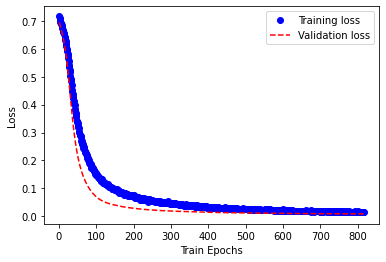

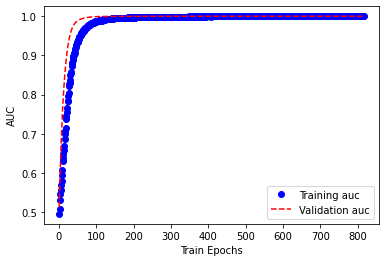

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

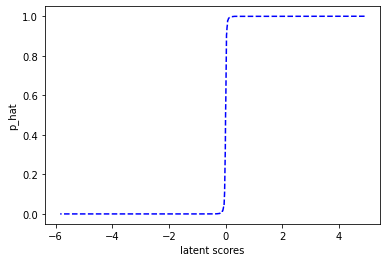

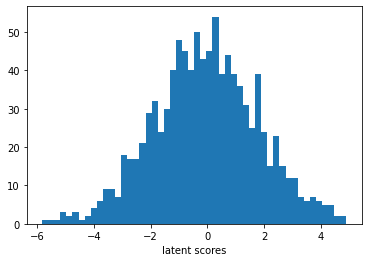

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

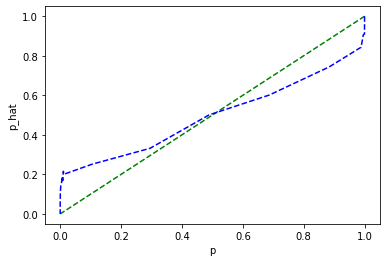

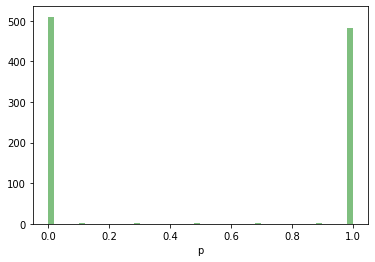

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

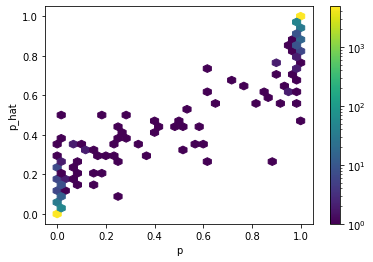

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

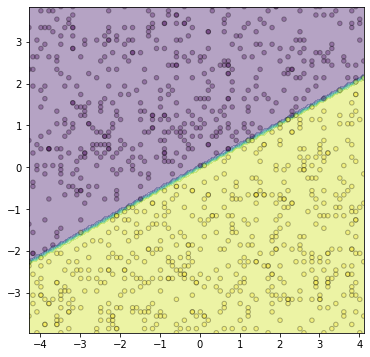

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.006,
 'batch': 256,
 'epoch': 590,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.007221716456115246, 'epoch': 816},
 'best_auc': {'auc': 0.9999867081642151, 'epoch': 774},
 'best_accuracy': {'accuracy': 0.9980000257492065, 'epoch': 815},
 'model': <keras.engine.sequential.Sequential at 0x7f4455715790>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.04139421507716179, 'epoch': 394},
  'best_auc': {'auc': 0.9996898770332336, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9901999831199646, 'epoch': 393}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.03228040039539337, 'epoch': 394},
  'best_auc': {'auc': 0.9997467994689941, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9912499785423279, 'epoch': 394}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.02498340792953968, 'epoch': 394},
  'best_auc': {'auc': 0.999853253364563, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9930999875068665, 'epoch': 391}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.00905443076044321, 'epoch': 823},
  'best_auc': {'auc': 0.9999814629554749, 'epoch': 810},

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25